In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from databroker.assets.handlers_base import HandlerBase
from collections import namedtuple


class PizzaBoxEncHandlerTxt(HandlerBase):
    encoder_row = namedtuple('encoder_row',
                             ['ts_s', 'ts_ns', 'encoder', 'index', 'state'])
    "Read PizzaBox text files using info from filestore."
    def __init__(self, fpath, chunk_size):
        self._fpath = fpath
        self.chunk_size = chunk_size
        with open(fpath, 'r') as f:
            self.lines = list(f)

    def __call__(self, chunk_num):
        cs = self.chunk_size
        return [self.encoder_row(*(int(v) for v in ln.split()))
                for ln in self.lines[chunk_num*cs:(chunk_num+1)*cs]]

    def get_file_list(self, chunk_num):
        return [self._fpath]


class PizzaBoxDIHandlerTxt(HandlerBase):
    di_row = namedtuple('di_row', ['ts_s', 'ts_ns', 'encoder', 'index', 'di'])
    "Read PizzaBox text files using info from filestore."
    def __init__(self, fpath, chunk_size):
        self._fpath = fpath
        self.chunk_size = chunk_size
        with open(fpath, 'r') as f:
            self.lines = list(f)

    def __call__(self, chunk_num):
        cs = self.chunk_size
        return [self.di_row(*(int(v) for v in ln.split()))
                for ln in self.lines[chunk_num*cs:(chunk_num+1)*cs]]

    def get_file_list(self, chunk_num):
        return [self._fpath]

class PizzaBoxAnHandlerTxt(HandlerBase):
    encoder_row = namedtuple('encoder_row', ['ts_s', 'ts_ns', 'index', 'adc'])
    "Read PizzaBox text files using info from filestore."

    bases = (10, 10, 10, 16)
    def __init__(self, fpath, chunk_size):
        self._fpath = fpath
        self.chunk_size = chunk_size
        # cludge : i just want filenames
        with open(fpath, 'r') as f:
            self.lines = list(f)
        
    def __call__(self, chunk_num):

        cs = self.chunk_size
        return [self.encoder_row(*(int(v, base=b) for v, b in zip(ln.split(), self.bases)))
                for ln in self.lines[chunk_num*cs:(chunk_num+1)*cs]]

    def get_file_list(self, chunk_num):
        #print("Chunk num : {}".format(chunk_num))
        return [self._fpath]


In [3]:
import os
from databroker import Broker

db = Broker.named("qas")

db.reg.register_handler('PIZZABOX_AN_FILE_TXT',
                        PizzaBoxAnHandlerTxt, overwrite=True)
db.reg.register_handler('PIZZABOX_ENC_FILE_TXT',
                        PizzaBoxEncHandlerTxt, overwrite=True)
db.reg.register_handler('PIZZABOX_DI_FILE_TXT',
                        PizzaBoxDIHandlerTxt, overwrite=True)



def get_dataset(uid, dataset_name):
    # In pizza box files, first column is seconds, tsecond nanosecs, third index fourth value
    hdr = db[uid]
    events = list(hdr.events(dataset_name))
    datum = events[0]['data'][dataset_name]
    resource = db.reg.resource_given_datum_id(datum)

    resource_id = resource['uid']

    # handler instance
    handler = db.reg.get_spec_handler(resource_id)

    # get the datum_kwargs, need a wrapper
    datums = list(db.reg.datum_gen_given_resource(resource_id))
    datum_kwargs = [datum['datum_kwargs'] for datum in datums]

    file_list = handler.get_file_list(datum_kwargs)

    print("loading from file {}".format(file_list[0]))
    gg=np.loadtxt(file_list[0])

    return gg



de55be30-dcd5-45b2-9a19-10142a4df62f
loading from file /nsls2/xf07bm/data/pizza_box_data/2018/04/06/an_dc1d0d


<IPython.core.display.Javascript object>


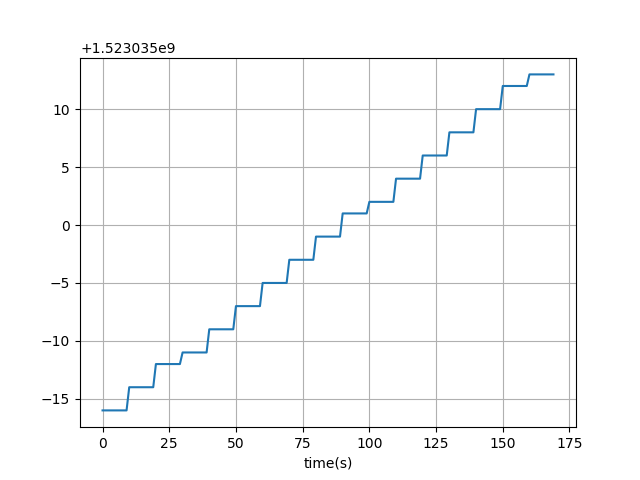

<IPython.core.display.Javascript object>


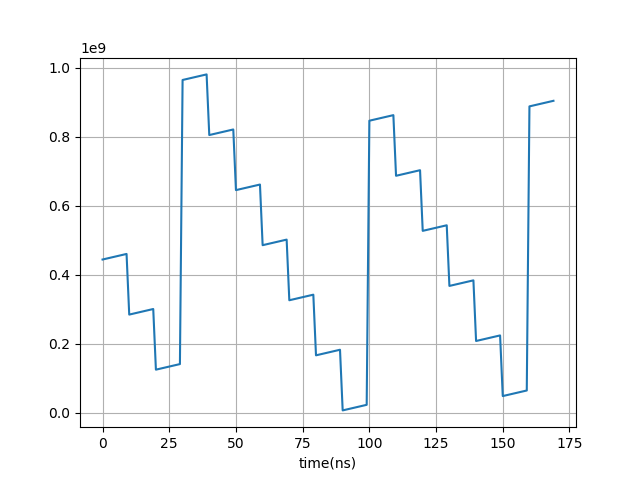

<IPython.core.display.Javascript object>


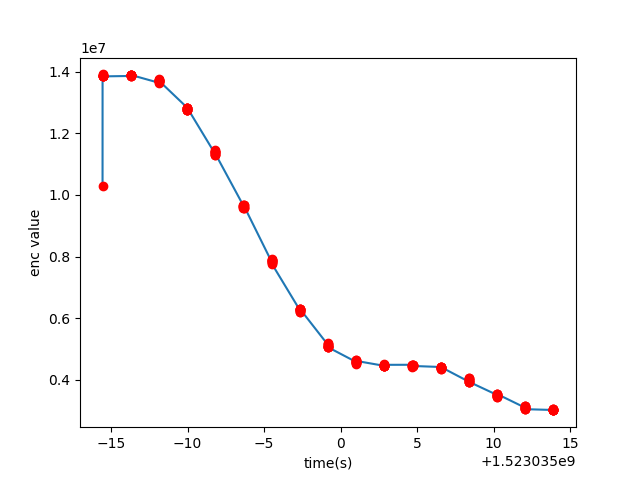

In [4]:
#corrupt data set:
uid = 'd28db86a-6020-4073-8ff4-1230e952ec8a'
dataset_name = 'pba1_adc7'
# (filename : /nsls2/xf07bm/data/pb_data/an_f65d22)


# good data set
uid = "49a7f2e2-04ea-4c86-a2f9-3814bf8a13de"

# Cu March 25th bad data set
uid = 'e7fb2250-fd68-4971-b589-cef552e075dd'


#uid = "1495401e-b1ea-4cd3-beaa-1b3eef4ad65e"

# find uid by most recent:
uid = db[-1].start['uid']
#dataset_name = 'pb1_enc1'
dataset_name = 'pba1_adc6'

# search by time
#hdrs = list(db(start_time="2018-03-08", stop_time="2018-03-09"))
#n = 1
#uid = hdrs[n].start['uid']



print(uid)

gg = get_dataset(uid, dataset_name)

#filename = '/nsls2/xf07bm/data/pb_data/an_e14b49'
#filename = '/nsls2/xf07bm/data/pb_data/an_af790c'

#filename = '/nsls2/xf08id/pizza_box_data/an_3640b1'

#gg=np.loadtxt(filename)

plt.figure()
plt.plot(gg[:,0])
plt.grid()
plt.xlabel("time(s)")

plt.figure()
plt.plot(gg[:,1])
plt.grid()
plt.xlabel("time(ns)")

# In pizza box files, first column is seconds, tsecond nanosecs, third index fourth value
# plot value versus time
plt.figure()
time=(gg[:,0]+gg[:,1]*1e-9)
plt.plot((gg[:,0]+gg[:,1]*1e-9),gg[:,3])
plt.plot((gg[:,0]+gg[:,1]*1e-9),gg[:,3], 'ro')
plt.xlabel("time(s)")
plt.ylabel("enc value")



In [5]:
# how to get datums (optional)
'''
hdr = db[-3]
hdr.stream_names

dataset_name = 'pba1_adc6'
events = list(hdr.events(dataset_name))
datum_ids = [event['data'][dataset_name] for event in events]
resources = [db.reg.resource_given_datum_id(datum) for datum in datum_ids]
datums = [db.reg.get_datum(datum_id) for datum_id in datum_ids]
'''
'''
result list()

for line in file:
    current_line = line.split()
    current_line[3] = int(current_line[3], 0) >> 8
    #print(current_line[3])
    if current_line[3] > 0x1FFFF:
        current_line[3] -= 0x40000
    current_line[3] = float(current_line[3]) * 7.62939453125e-05
    #print(str(current_line[0]),  str(current_line[1]), str(current_line[2]), str(current_line[3]))
    output.write("%s" %str(current_line[0]) + "  " + "%s" %str(current_line[1]) + "  " + "%s" %str(current_line[2])
                  + "  " + "%s\n" %str(current_line[3]))

output.close()
file.close()

'''


'\nresult list()\n\nfor line in file:\n    current_line = line.split()\n    current_line[3] = int(current_line[3], 0) >> 8\n    #print(current_line[3])\n    if current_line[3] > 0x1FFFF:\n        current_line[3] -= 0x40000\n    current_line[3] = float(current_line[3]) * 7.62939453125e-05\n    #print(str(current_line[0]),  str(current_line[1]), str(current_line[2]), str(current_line[3]))\n    output.write("%s" %str(current_line[0]) + "  " + "%s" %str(current_line[1]) + "  " + "%s" %str(current_line[2])\n                  + "  " + "%s\n" %str(current_line[3]))\n\noutput.close()\nfile.close()\n\n'

In [6]:
from qastools.interpolation import interpolate_and_save


In [7]:
res = interpolate_and_save("qas", "qas-analysis", uid)


subtracting offset
0.0502556457865333
subtracting offset
0.04964022819022222
Converting to energy, using key mono1_enc


<IPython.core.display.Javascript object>


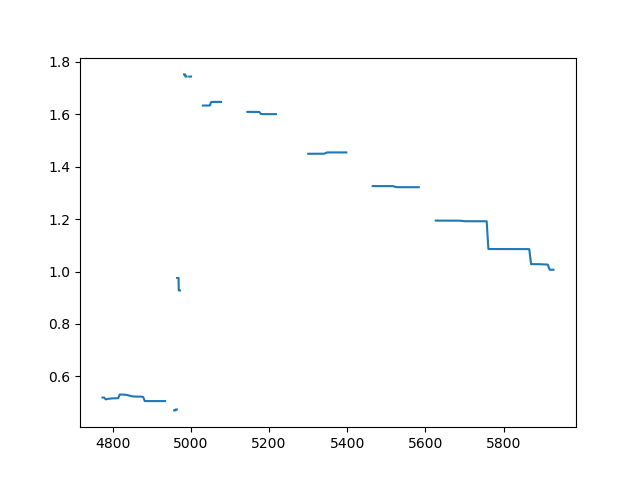

In [8]:
bin_df = res['bin_df']
plt.figure();plt.clf();
plt.plot(bin_df.energy, np.log(bin_df.i0/bin_df.it))